In [1]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from functools import reduce  
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
p = 7
n = 1000
min_cor = 0
max_cor = 0

true_betas = np.array(np.repeat(5, p))
true_betas

array([5, 5, 5, 5, 5, 5, 5])

In [3]:
def get_sim_data(p, n, min_cor, max_cor, true_betas):
    
    sd_vec = np.ones(p) 
    mean = np.zeros(p)
    cor_matrix = np.zeros((p,p))

    correlation = np.random.uniform(min_cor, max_cor, int(p * (p - 1) / 2))
    cor_matrix[np.triu_indices(p, 1)] = correlation
    cor_matrix[np.tril_indices(p, -1)] = cor_matrix.T[np.tril_indices(p, -1)]
    np.fill_diagonal(cor_matrix, 1)


    D = np.diag(sd_vec)
    sigma = D.dot(cor_matrix).dot(D)

    X = np.random.multivariate_normal(mean, sigma, n)
    eps = np.random.normal(0, 1, n)
    
    y_true = X.dot(true_betas)
    y_true = pd.Series(y_true, name = 'y_true')

    y_noise = y_true + eps 
    y_noise = pd.Series(y_noise, name = 'y_noise')
    
    column_names = []
    
    for value in range(1, p + 1): 
        
        column = f"X_{value}"
        column_names.append(column)
        
    
    X = pd.DataFrame(X, columns = column_names)
    
    df = pd.concat([y_noise, X], axis = 1)
    
    return y_true, y_noise, X, df



In [4]:
y_true, y_noise, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas)


In [5]:
y_true

0       8.881687
1      -3.854505
2     -18.073435
3       3.495024
4     -17.212692
         ...    
995     5.440486
996     5.338028
997    -2.403603
998    16.018135
999    -3.552242
Name: y_true, Length: 1000, dtype: float64

In [6]:
y_noise

0       7.795783
1      -3.891909
2     -20.344782
3       4.115199
4     -17.846176
         ...    
995     6.053234
996     5.873703
997    -2.156716
998    16.447672
999    -2.366481
Name: y_noise, Length: 1000, dtype: float64

In [8]:
"""Zero multicollinearity.
   n = 30; p = 2, 28, 30, 35. 
"""
np.random.seed(123)

n_sim = 30
p_sim = np.array([2, 28, 30, 35])

min_corr_sim = 0
max_corr_sim = 0 
iterations_sim = 1000

matrix_betas_final = []
matrix_betas_mean = []
matrix_bias_sq = []
matrix_betas_var_mean = []
matrix_betas_var_final = []


    
for p in p_sim: 
    
    matrix_var = []
    matrix_betas = []
    
    for i in range(iterations_sim):
    
        true_betas_sim = np.repeat(5, p)
    
        y, X, df = get_sim_data(p, n_sim, min_corr_sim, max_corr_sim, true_betas_sim) 

        var_cov = np.linalg.inv(np.dot(X.T, X))
        var_betas = var_cov.diagonal() 
        
        #reg = LinearRegression().fit(X, y)
        betas = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        
        #matrix_betas.append(reg.coef_)
        matrix_betas.append(betas)
        
        matrix_var.append(var_betas)
        
        X_names = []
        beta_names = []
    
        for value in range(1, p + 1): 
            
            column_X = f"X_{value}"
            column_betas = f"beta_{value}"
            X_names.append(column_X)
            beta_names.append(column_betas)
        
        df_var = pd.DataFrame(matrix_var, columns = X_names)
        df_betas = pd.DataFrame(matrix_betas, columns = beta_names) 
        
        #bias_squared = (df_betas.mean() - true_betas_sim)**2
        
    matrix_betas_final.append(df_betas)
    matrix_betas_mean.append(df_betas.mean())
    #matrix_bias_sq.append(bias_squared)
    matrix_betas_var_mean.append(df_var.mean())
    matrix_betas_var_final.append(df_var)
    
 

In [13]:
#matrix_betas_var_mean[1]
#matrix_betas_mean[0]
#matrix_betas_var_mean[2]
#matrix_betas_var_mean[3]
#matrix_betas_var_mean[4]
#matrix_betas_var_mean[5]
#matrix_betas_var_final
#len(matrix_betas_final)
matrix_betas_var_final[0].mean()


X_1    0.036542
X_2    0.037256
dtype: float64

In [15]:
def iterate_ridge(n, p, min_cor, max_cor, iterations_sim, true_betas, alphas):
    
    beta_var_names = []
    ridge_beta_names = []
    
    for value in range(1, p + 1): 
    
        column_betas_var = f"beta_var_{value}"
        column_betas = f"beta_{value}"
        beta_var_names.append(column_betas_var)
        ridge_beta_names.append(column_betas)

    df_list_betas_ridge = []
    df_list_var_ridge = []

    for i in range(iterations_sim):
        
        true_betas_sim = true_betas
    
        y, X, df = get_sim_data(p, n, min_cor, max_cor, true_betas_sim) 
        
        i, k = X.shape
        I = np.identity(k)
    
        matr_var = []
        matr_beta = []
    

        for a in alphas: 
        
            ridge_beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), X.T), y)
            matr_beta.append(ridge_beta)
            df_ridge_betas = pd.DataFrame(matr_beta, columns = ridge_beta_names)
        
            ridge_var_cov = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + a * I), np.dot(X.T, X)), np.linalg.inv(np.dot(X.T, X) + a * I))
            ridge_var = ridge_var_cov.diagonal()
            matr_var.append(ridge_var)
            df_ridge_var = pd.DataFrame(matr_var, columns = beta_var_names)
        
         
        df_list_betas_ridge.append(df_ridge_betas)
        df_list_var_ridge.append(df_ridge_var)
        
    return df_list_betas_ridge, df_list_var_ridge



In [16]:
np.random.seed(20)

p_regressors = [2, 28, 30, 35]
n = 30
#true_betas = np.repeat(5, p)
min_cor = 0 
max_cor = 0 
iterations = 1

alphas = np.array([int(0), 0.00000000000000000001, 0.00000000000001, 0.000000000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 15, 20, 30, 50, 100, 120])


collect_ridge_betas = []
collect_ridge_var = []

for p in p_regressors: 
    
    ridge_betas, beta_var = iterate_ridge(n, p, min_cor, max_cor, iterations, np.repeat(5, p), alphas)
    collect_ridge_betas.append(ridge_betas)
    collect_ridge_var.append(beta_var)
    
    


In [17]:
collect_ridge_betas[1][0]

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,beta_25,beta_26,beta_27,beta_28
0,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
1,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
2,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
3,5.562578,5.791019,5.988475,4.194155,6.194273,5.834038,5.239480,6.580482,3.945802,5.710267,...,5.926149,3.890834,5.754095,4.052448,4.317577,5.941545,6.190429,4.645697,4.257556,4.706766
4,5.562577,5.791018,5.988473,4.194157,6.194270,5.834036,5.239480,6.580478,3.945803,5.710266,...,5.926145,3.890836,5.754093,4.052451,4.317579,5.941543,6.190425,4.645697,4.257558,4.706767
5,5.562568,5.791001,5.988456,4.194170,6.194241,5.834017,5.239480,6.580444,3.945821,5.710253,...,5.926112,3.890854,5.754077,4.052476,4.317596,5.941533,6.190397,4.645702,4.257574,4.706779
6,5.562476,5.790830,5.988280,4.194307,6.193958,5.833829,5.239480,6.580106,3.945996,5.710123,...,5.925777,3.891043,5.753908,4.052724,4.317760,5.941427,6.190109,4.645749,4.257734,4.706900
7,5.561554,5.789128,5.986528,4.195669,6.191125,5.831947,5.239482,6.576732,3.947742,5.708822,...,5.922434,3.892923,5.752224,4.055202,4.319404,5.940370,6.187239,4.646216,4.259337,4.708108
8,5.552400,5.772289,5.969162,4.209170,6.163065,5.813299,5.239519,6.543305,3.965017,5.695956,...,5.889318,3.911531,5.735532,4.079727,4.335641,5.929891,6.158819,4.650839,4.275193,4.720059
9,5.466586,5.620077,5.810032,4.332668,5.906708,5.642026,5.241198,6.237534,4.120673,5.579524,...,5.587134,4.079886,5.582470,4.301698,4.479988,5.833167,5.899941,4.692051,4.418479,4.828234


In [18]:
def plot_ridge_regression(alphas, ridge_betas): 

    ax = plt.gca()
    
    ax.plot(alphas, ridge_betas)
    
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.rcParams["figure.figsize"] = (30,20)
    plt.xlabel("alpha", fontsize = 30)
    plt.ylabel("weights", fontsize = 30)
    
    ax.tick_params(axis='both', which='major', labelsize=25)

    plt.title("Ridge coefficients as a function of the regularization", fontsize = 35)
    plt.axis("tight")
    plt.show()



$$
V\left(\hat{\boldsymbol{\beta}}^{*}\right)=\sigma^{2}\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}\left(\mathbf{X}^{\prime} \mathbf{X}\right)\left[\mathbf{X}^{\prime} \mathbf{X}+k \mathbf{I}\right]^{-1}.
$$

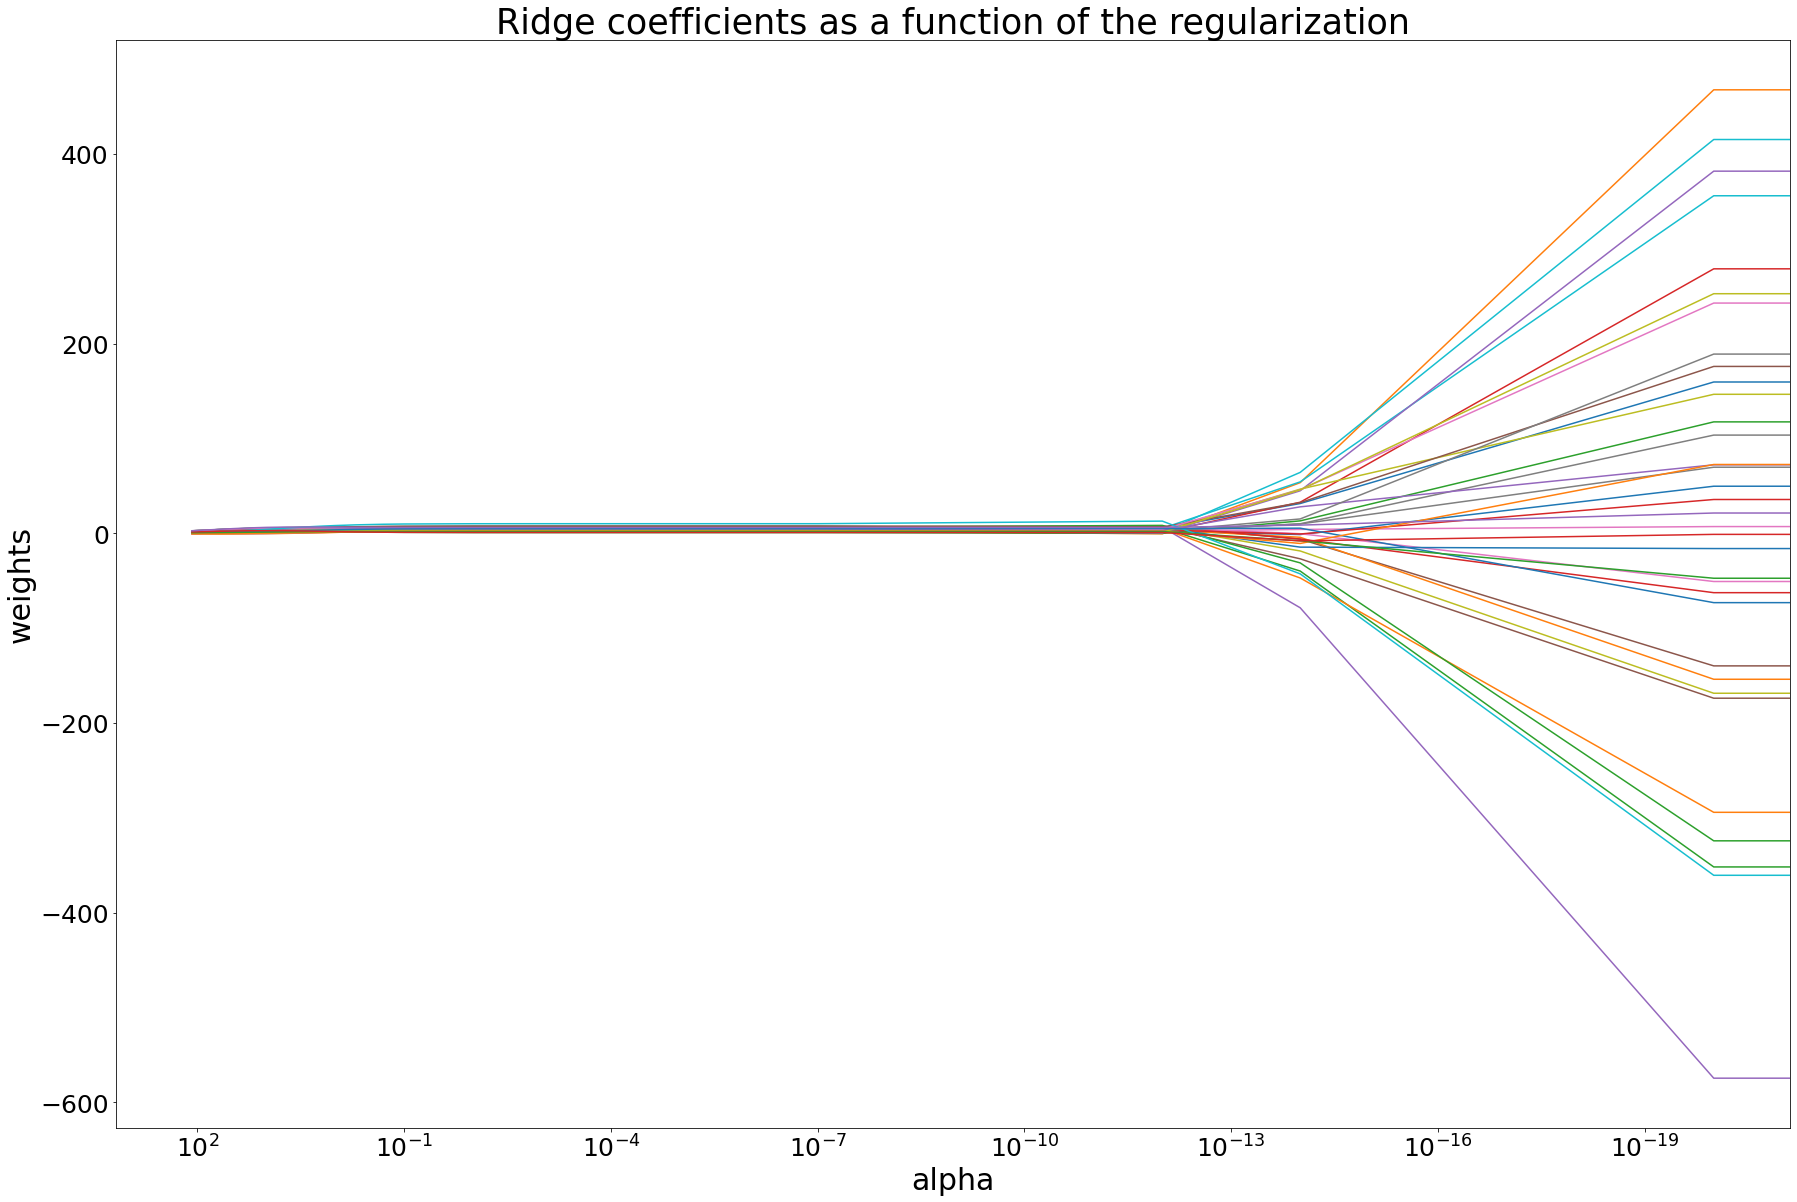

In [23]:
plot_ridge_regression(alphas, collect_ridge_betas[3][0])



In [24]:
np.random.seed(159)

n = 30
min_cor = 0 
max_cor = 0 
iterations_sim = 1000
true_betas = np.repeat(5, p)

alphas = np.array([0, 0.00000000000000000001, 0.00000000000001, 0.000000000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 15, 20]) 

df_list_betas_ridge_28, df_list_var_ridge_28 = iterate_ridge(n, 28, min_cor, max_cor, iterations_sim, np.repeat(5, 28), alphas)

mean_df_list_betas_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_28) / iterations_sim
mean_df_list_var_ridge_28 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_28) / iterations_sim

mean_df_list_betas_ridge_28
mean_df_list_betas_ridge_28["alpha"] = alphas
mean_df_list_betas_ridge_28.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_28
    
mean_df_list_var_ridge_28
mean_df_list_var_ridge_28["alpha"] = alphas
mean_df_list_var_ridge_28.set_index("alpha", inplace = True)
mean_df_list_var_ridge_28


,beta_var_1,beta_var_2,beta_var_3,beta_var_4,beta_var_5,beta_var_6,beta_var_7,beta_var_8,beta_var_9,beta_var_10,...,beta_var_19,beta_var_20,beta_var_21,beta_var_22,beta_var_23,beta_var_24,beta_var_25,beta_var_26,beta_var_27,beta_var_28
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,1.154005,1.033463,1.062281,1.111585,1.084819,0.958145,1.042437,1.168249,0.951037,1.296454,...,1.115764,0.904155,0.994906,0.839637,1.063106,1.135098,1.169798,1.056703,0.996447,1.119178
1.000000e-20,1.154005,1.033463,1.062281,1.111585,1.084819,0.958145,1.042437,1.168249,0.951037,1.296454,...,1.115764,0.904155,0.994906,0.839637,1.063106,1.135098,1.169798,1.056703,0.996447,1.119178
1.000000e-14,1.154005,1.033463,1.062281,1.111585,1.084819,0.958145,1.042437,1.168249,0.951037,1.296454,...,1.115764,0.904155,0.994906,0.839637,1.063106,1.135098,1.169798,1.056703,0.996447,1.119178
1.000000e-12,1.154005,1.033463,1.062281,1.111585,1.084819,0.958145,1.042437,1.168249,0.951037,1.296454,...,1.115764,0.904155,0.994906,0.839637,1.063106,1.135098,1.169798,1.056703,0.996447,1.119178
1.000000e-07,1.153942,1.033352,1.062232,1.111440,1.084780,0.958063,1.042399,1.168128,0.950979,1.296257,...,1.115670,0.904138,0.994837,0.839623,1.063024,1.134984,1.169738,1.056582,0.996381,1.119051
1.000000e-06,1.153376,1.032355,1.061795,1.110133,1.084430,0.957324,1.042052,1.167047,0.950455,1.294483,...,1.114824,0.903990,0.994223,0.839491,1.062285,1.133967,1.169191,1.055490,0.995785,1.117908
1.000000e-05,1.147811,1.022752,1.057525,1.097550,1.080961,0.950177,1.038624,1.156598,0.945372,1.277373,...,1.106611,0.902522,0.988280,0.838195,1.055104,1.124153,1.163810,1.044970,0.990026,1.106884
1.000000e-04,1.100114,0.953279,1.022284,1.007266,1.049434,0.896664,1.007740,1.078787,0.906172,1.152591,...,1.043173,0.889406,0.943474,0.826919,0.998496,1.052282,1.116943,0.968449,0.946747,1.026294
1.000000e-03,0.892618,0.794993,0.871567,0.815595,0.883702,0.754079,0.849070,0.874060,0.779029,0.869741,...,0.851059,0.813961,0.812549,0.763808,0.814682,0.870807,0.907771,0.785081,0.825085,0.827944


In [25]:
mean_df_list_betas_ridge_28

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_19,beta_20,beta_21,beta_22,beta_23,beta_24,beta_25,beta_26,beta_27,beta_28
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,4.941030,5.035232,5.007396,5.009905,5.047606,4.960237,4.990033,5.017430,4.953106,4.996454,...,5.006803,4.972181,5.023533,5.043405,5.006744,5.018984,5.010822,4.946738,4.969571,4.980167
1.000000e-20,4.941030,5.035232,5.007396,5.009905,5.047606,4.960237,4.990033,5.017430,4.953106,4.996454,...,5.006803,4.972181,5.023533,5.043405,5.006744,5.018984,5.010822,4.946738,4.969571,4.980167
1.000000e-14,4.941030,5.035232,5.007396,5.009905,5.047606,4.960237,4.990033,5.017430,4.953106,4.996454,...,5.006803,4.972181,5.023533,5.043405,5.006744,5.018984,5.010822,4.946738,4.969571,4.980167
1.000000e-12,4.941030,5.035232,5.007396,5.009905,5.047606,4.960237,4.990033,5.017430,4.953106,4.996454,...,5.006803,4.972181,5.023533,5.043405,5.006744,5.018984,5.010822,4.946738,4.969571,4.980167
1.000000e-07,4.941029,5.035227,5.007393,5.009909,5.047605,4.960240,4.990032,5.017424,4.953109,4.996448,...,5.006800,4.972179,5.023529,5.043405,5.006746,5.018979,5.010824,4.946733,4.969573,4.980162
1.000000e-06,4.941027,5.035178,5.007365,5.009947,5.047595,4.960274,4.990020,5.017377,4.953139,4.996400,...,5.006775,4.972162,5.023488,5.043404,5.006765,5.018936,5.010839,4.946689,4.969590,4.980117
1.000000e-05,4.941002,5.034697,5.007090,5.010319,5.047493,4.960607,4.989909,5.016911,4.953430,4.995928,...,5.006531,4.971997,5.023087,5.043391,5.006950,5.018507,5.010992,4.946258,4.969755,4.979675
1.000000e-04,4.940963,5.030737,5.004771,5.013123,5.046450,4.963233,4.988924,5.013074,4.955772,4.992241,...,5.004644,4.970526,5.019716,5.043116,5.008282,5.015045,5.012202,4.942812,4.970877,4.976136
1.000000e-03,4.943170,5.014794,4.994588,5.017401,5.037200,4.969602,4.982640,4.997662,4.962455,4.982163,...,4.998692,4.962076,5.004798,5.037254,5.008373,5.002904,5.013876,4.932077,4.969483,4.964714


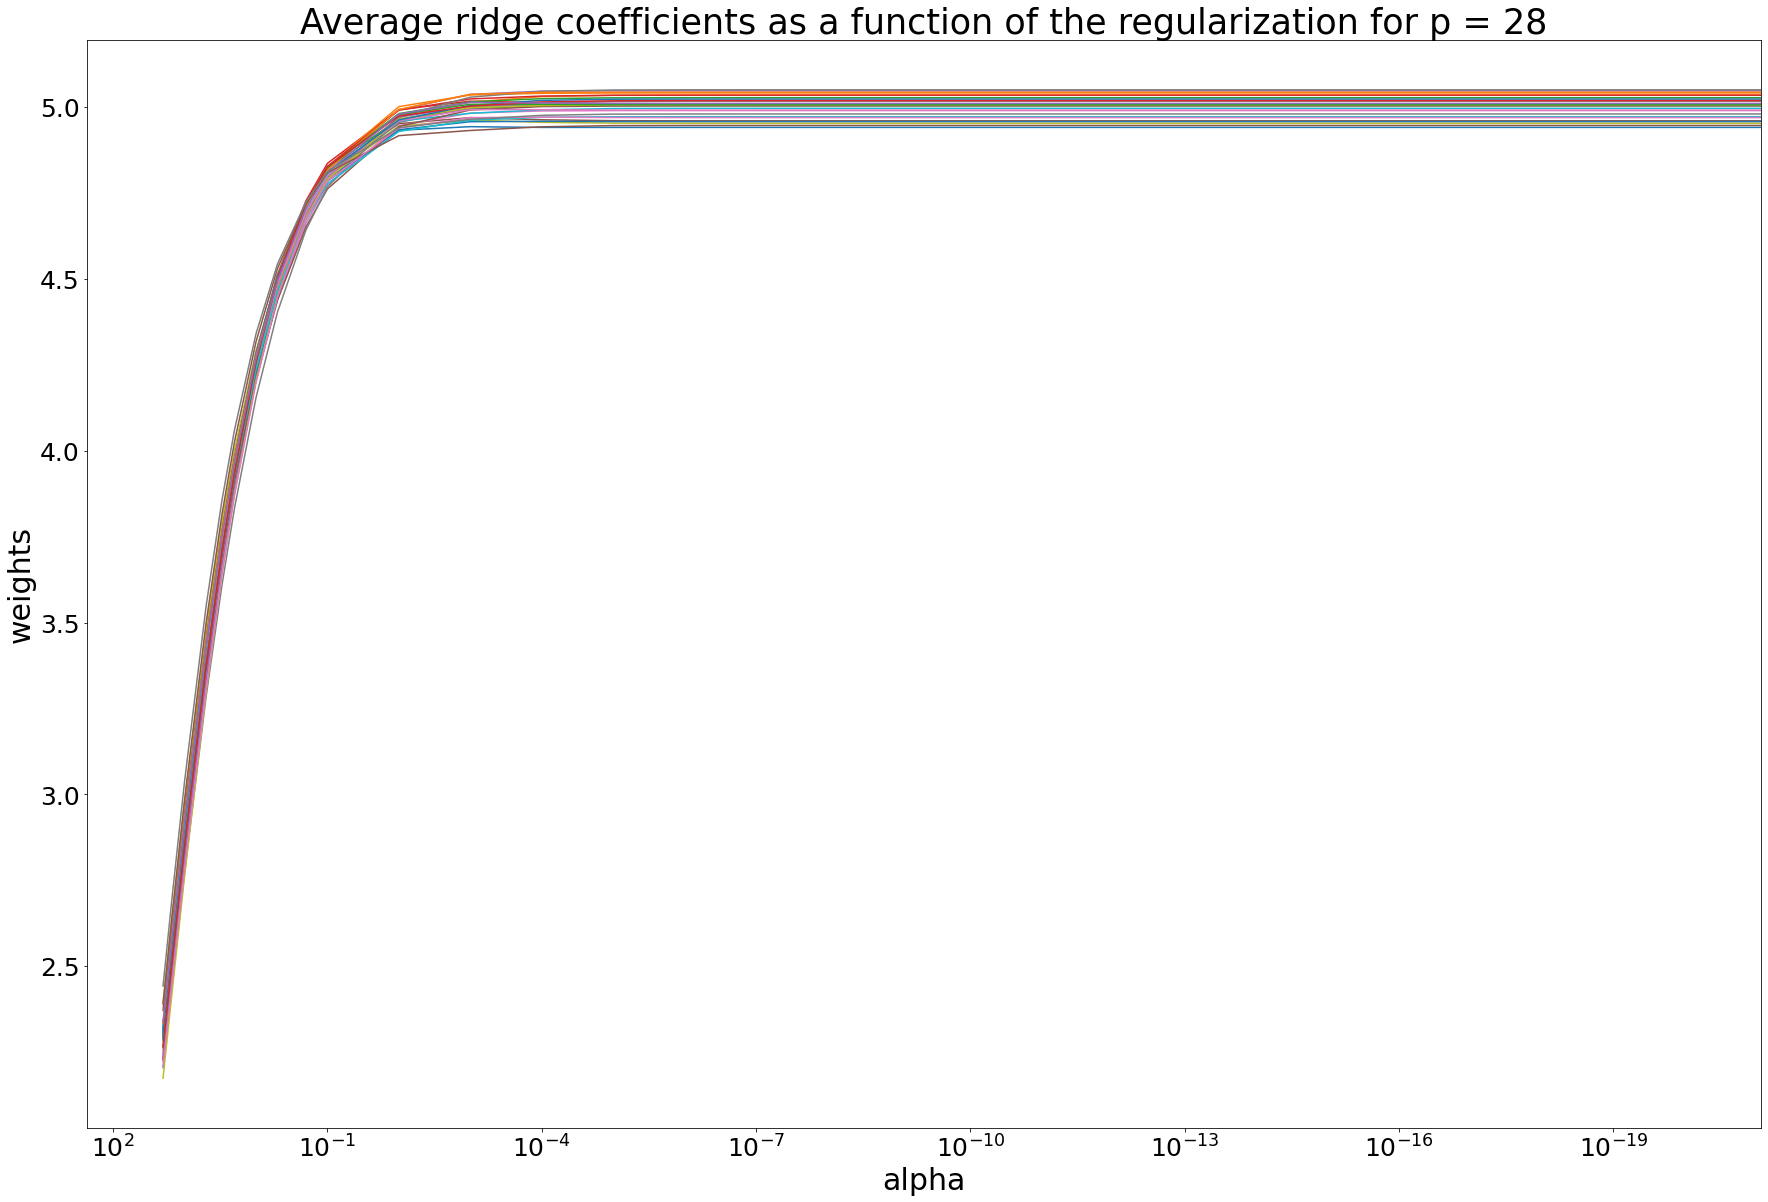

In [26]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_28)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.title("Average ridge coefficients as a function of the regularization for p = 28", fontsize = 35)
plt.axis("tight")
plt.show()




In [27]:
df_list_betas_ridge_2, df_list_var_ridge_2 = iterate_ridge(n, 2, min_cor, max_cor, iterations_sim, np.repeat(5, 2), alphas)

mean_df_list_betas_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_2) / iterations_sim
mean_df_list_var_ridge_2 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_2) / iterations_sim

mean_df_list_betas_ridge_2
mean_df_list_betas_ridge_2["alpha"] = alphas
mean_df_list_betas_ridge_2.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_2
    
mean_df_list_var_ridge_2
mean_df_list_var_ridge_2["alpha"] = alphas
mean_df_list_var_ridge_2.set_index("alpha", inplace = True)
mean_df_list_var_ridge_2

,beta_var_1,beta_var_2
alpha,,
0.000000e+00,0.036871,0.036899
1.000000e-20,0.036871,0.036899
1.000000e-14,0.036871,0.036899
1.000000e-12,0.036871,0.036899
1.000000e-07,0.036871,0.036899
1.000000e-06,0.036871,0.036899
1.000000e-05,0.036871,0.036899
1.000000e-04,0.036870,0.036899
1.000000e-03,0.036868,0.036896


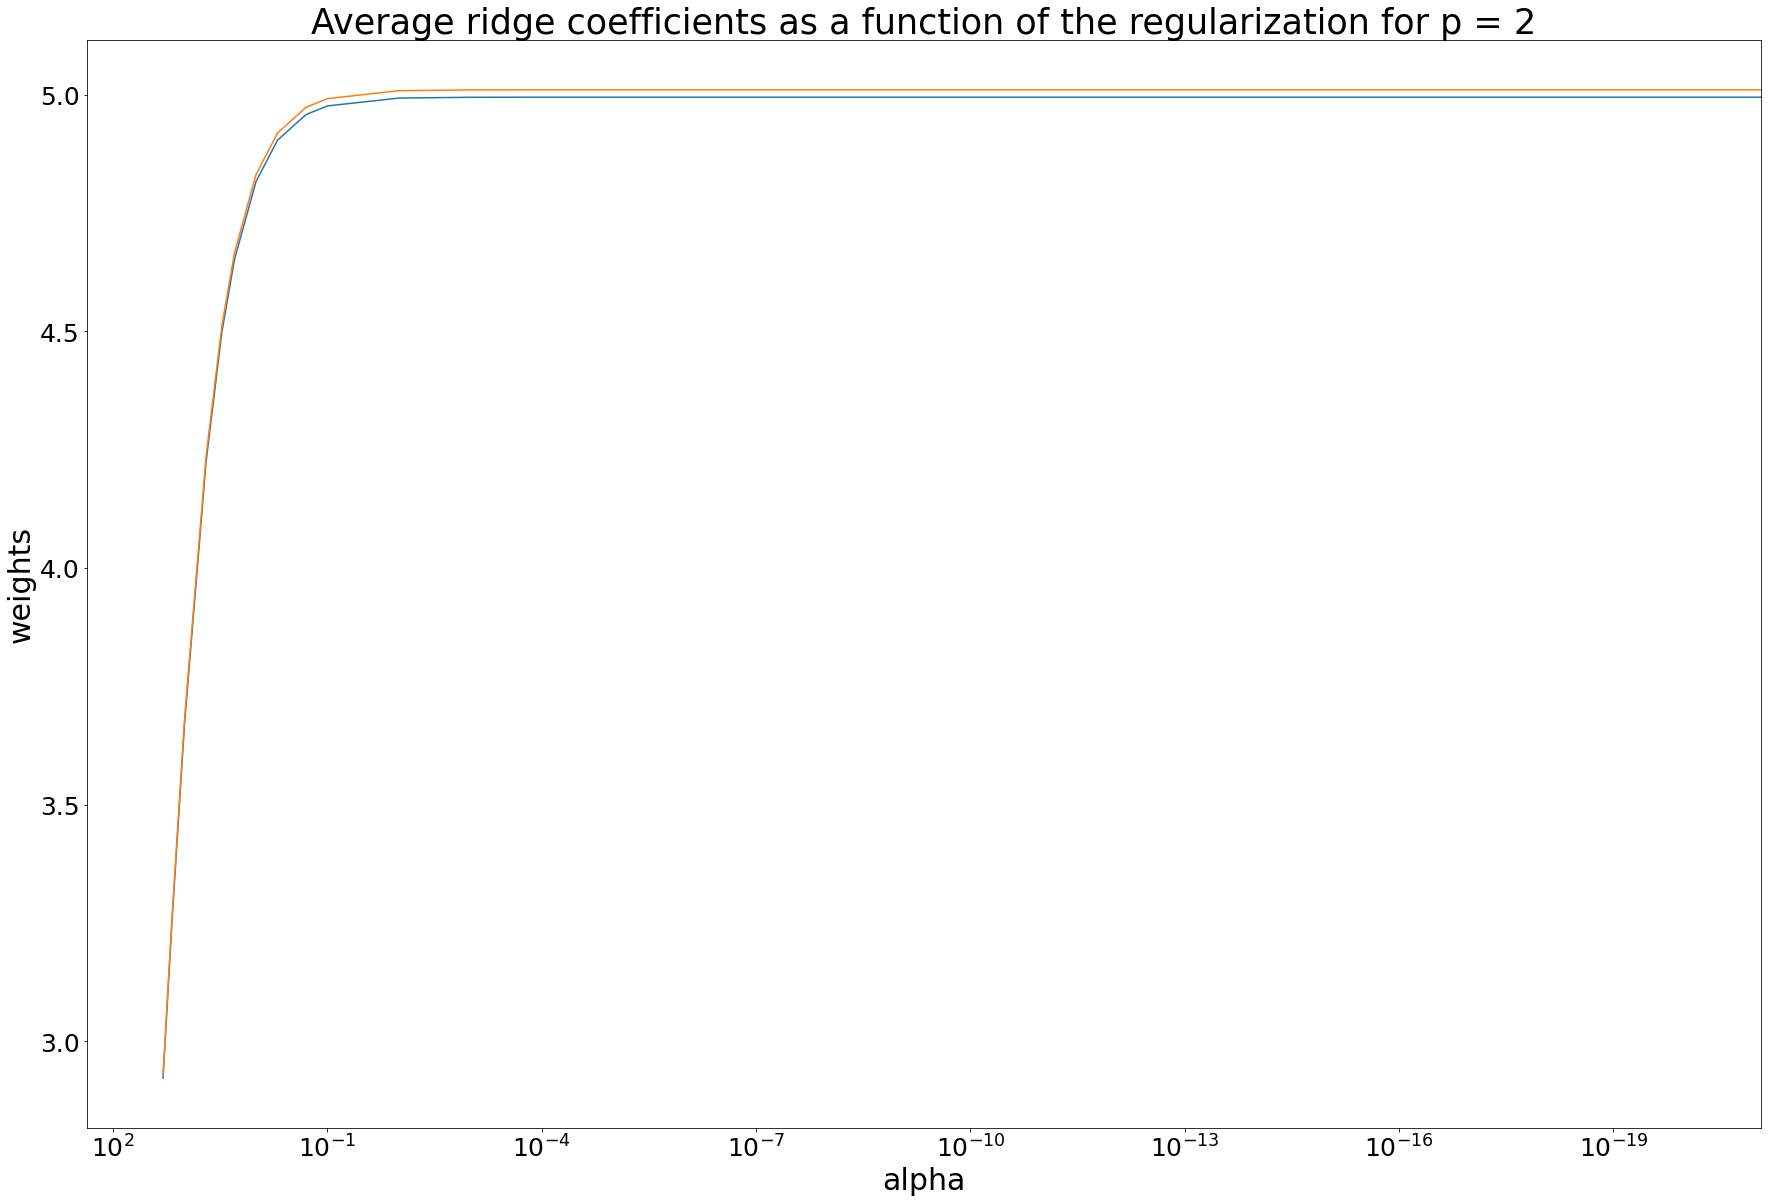

In [28]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_2)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.title("Average ridge coefficients as a function of the regularization for p = 2", fontsize = 35)
plt.axis("tight")
plt.show()



In [29]:
df_list_betas_ridge_30, df_list_var_ridge_30 = iterate_ridge(n, 30, min_cor, max_cor, iterations_sim, np.repeat(5, 30), alphas)

mean_df_list_betas_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_30) / iterations_sim
mean_df_list_var_ridge_30 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_30) / iterations_sim

mean_df_list_betas_ridge_30
mean_df_list_betas_ridge_30["alpha"] = alphas
mean_df_list_betas_ridge_30.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_30
    
mean_df_list_var_ridge_30
mean_df_list_var_ridge_30["alpha"] = alphas
mean_df_list_var_ridge_30.set_index("alpha", inplace = True)
mean_df_list_var_ridge_30

,beta_var_1,beta_var_2,beta_var_3,beta_var_4,beta_var_5,beta_var_6,beta_var_7,beta_var_8,beta_var_9,beta_var_10,...,beta_var_21,beta_var_22,beta_var_23,beta_var_24,beta_var_25,beta_var_26,beta_var_27,beta_var_28,beta_var_29,beta_var_30
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,467.796082,234.895029,817.524288,997.720932,182.636992,192.800471,459.362609,263.346481,336.399323,195.283577,...,160.673113,315.619724,426.133187,130.069757,780.639376,266.638905,291.293375,258.103602,597.100837,626.077095
1.000000e-20,467.796082,234.895029,817.524288,997.720932,182.636992,192.800471,459.362609,263.346481,336.399323,195.283577,...,160.673113,315.619724,426.133187,130.069757,780.639376,266.638905,291.293375,258.103602,597.100837,626.077095
1.000000e-14,467.796063,234.895026,817.524243,997.720871,182.636988,192.800470,459.362597,263.346471,336.399312,195.283575,...,160.673110,315.619717,426.133165,130.069754,780.639338,266.638898,291.293369,258.103598,597.100812,626.077079
1.000000e-12,467.794106,234.894729,817.519578,997.714604,182.636410,192.800282,459.361065,263.345384,336.398009,195.283355,...,160.672756,315.618932,426.130962,130.069454,780.635502,266.638082,291.292806,258.103126,597.098109,626.074941
1.000000e-07,338.829772,210.851909,518.277293,605.905968,140.942903,176.532189,347.820118,192.399901,248.052307,177.405886,...,136.646284,260.030042,287.049853,110.006795,526.651976,210.086628,250.592569,222.184978,420.026571,476.830504
1.000000e-06,139.038493,138.293229,150.258976,156.589504,66.911458,108.759955,135.587948,90.419237,108.740798,112.800084,...,88.146640,134.184800,113.077686,72.117753,167.339184,102.349988,146.241333,130.007702,156.098334,205.840517
1.000000e-05,43.353958,57.382907,40.246837,38.793379,31.527365,37.090184,38.903324,34.685130,43.862787,42.912380,...,38.510307,43.478499,39.876393,35.060499,43.545599,36.492767,48.701284,47.556588,43.487897,51.631679
1.000000e-04,13.771787,13.979961,12.443243,12.459851,11.454463,12.232146,12.416043,11.236773,14.384541,14.034122,...,12.156265,13.976649,13.795619,12.946380,13.225988,12.545183,13.059565,13.534423,12.048032,12.509674
1.000000e-03,4.007267,3.835672,3.754677,3.802118,3.695125,3.851563,3.835720,3.568487,3.867944,3.676390,...,3.736217,4.088434,4.146397,3.854653,4.014914,3.680966,4.029242,4.124676,3.516817,3.828007


In [30]:
mean_df_list_betas_ridge_30

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_21,beta_22,beta_23,beta_24,beta_25,beta_26,beta_27,beta_28,beta_29,beta_30
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,5.494574,5.225096,4.650235,4.657660,5.283528,5.287026,5.053445,6.002132,5.791328,4.258575,...,5.046906,4.663903,5.074845,5.340592,4.295821,4.359716,5.816462,4.488542,4.852541,3.924400
1.000000e-20,5.494574,5.225096,4.650235,4.657660,5.283528,5.287026,5.053445,6.002132,5.791328,4.258575,...,5.046906,4.663903,5.074845,5.340592,4.295821,4.359716,5.816462,4.488542,4.852541,3.924400
1.000000e-14,5.494574,5.225096,4.650235,4.657660,5.283528,5.287026,5.053445,6.002132,5.791328,4.258575,...,5.046906,4.663903,5.074845,5.340592,4.295821,4.359716,5.816462,4.488542,4.852541,3.924400
1.000000e-12,5.494573,5.225096,4.650238,4.657659,5.283527,5.287026,5.053443,6.002131,5.791326,4.258576,...,5.046906,4.663903,5.074844,5.340592,4.295822,4.359716,5.816461,4.488543,4.852542,3.924399
1.000000e-07,5.393516,5.166558,4.852553,4.626543,5.221310,5.263941,4.928351,5.875661,5.648501,4.270795,...,5.080002,4.711663,5.009430,5.346974,4.382562,4.371141,5.777414,4.545624,4.913953,3.806233
1.000000e-06,5.185466,5.002403,5.257328,4.728830,5.070314,5.182858,4.710751,5.511912,5.265166,4.435964,...,5.114047,4.832302,4.936374,5.356348,4.713917,4.497750,5.499376,4.710366,5.004881,3.718001
1.000000e-05,5.058454,4.949442,5.186203,4.938141,5.022697,5.138759,4.829017,5.220507,4.999658,4.815195,...,5.022587,4.877516,5.092227,5.276395,4.976429,4.820171,5.094157,4.936258,5.008645,4.322200
1.000000e-04,5.016820,5.048854,5.066104,4.943533,4.960171,5.097654,4.899830,5.038448,4.914999,4.938052,...,5.028452,4.930692,5.146402,5.122930,4.896606,4.925783,5.094452,5.020218,4.999844,4.876479
1.000000e-03,5.001945,5.017207,4.991283,4.914821,4.969516,4.986262,4.896989,4.995721,4.902911,4.957274,...,5.053530,4.985577,5.071007,5.020622,4.857638,4.945740,5.022393,4.963289,4.989779,4.979708


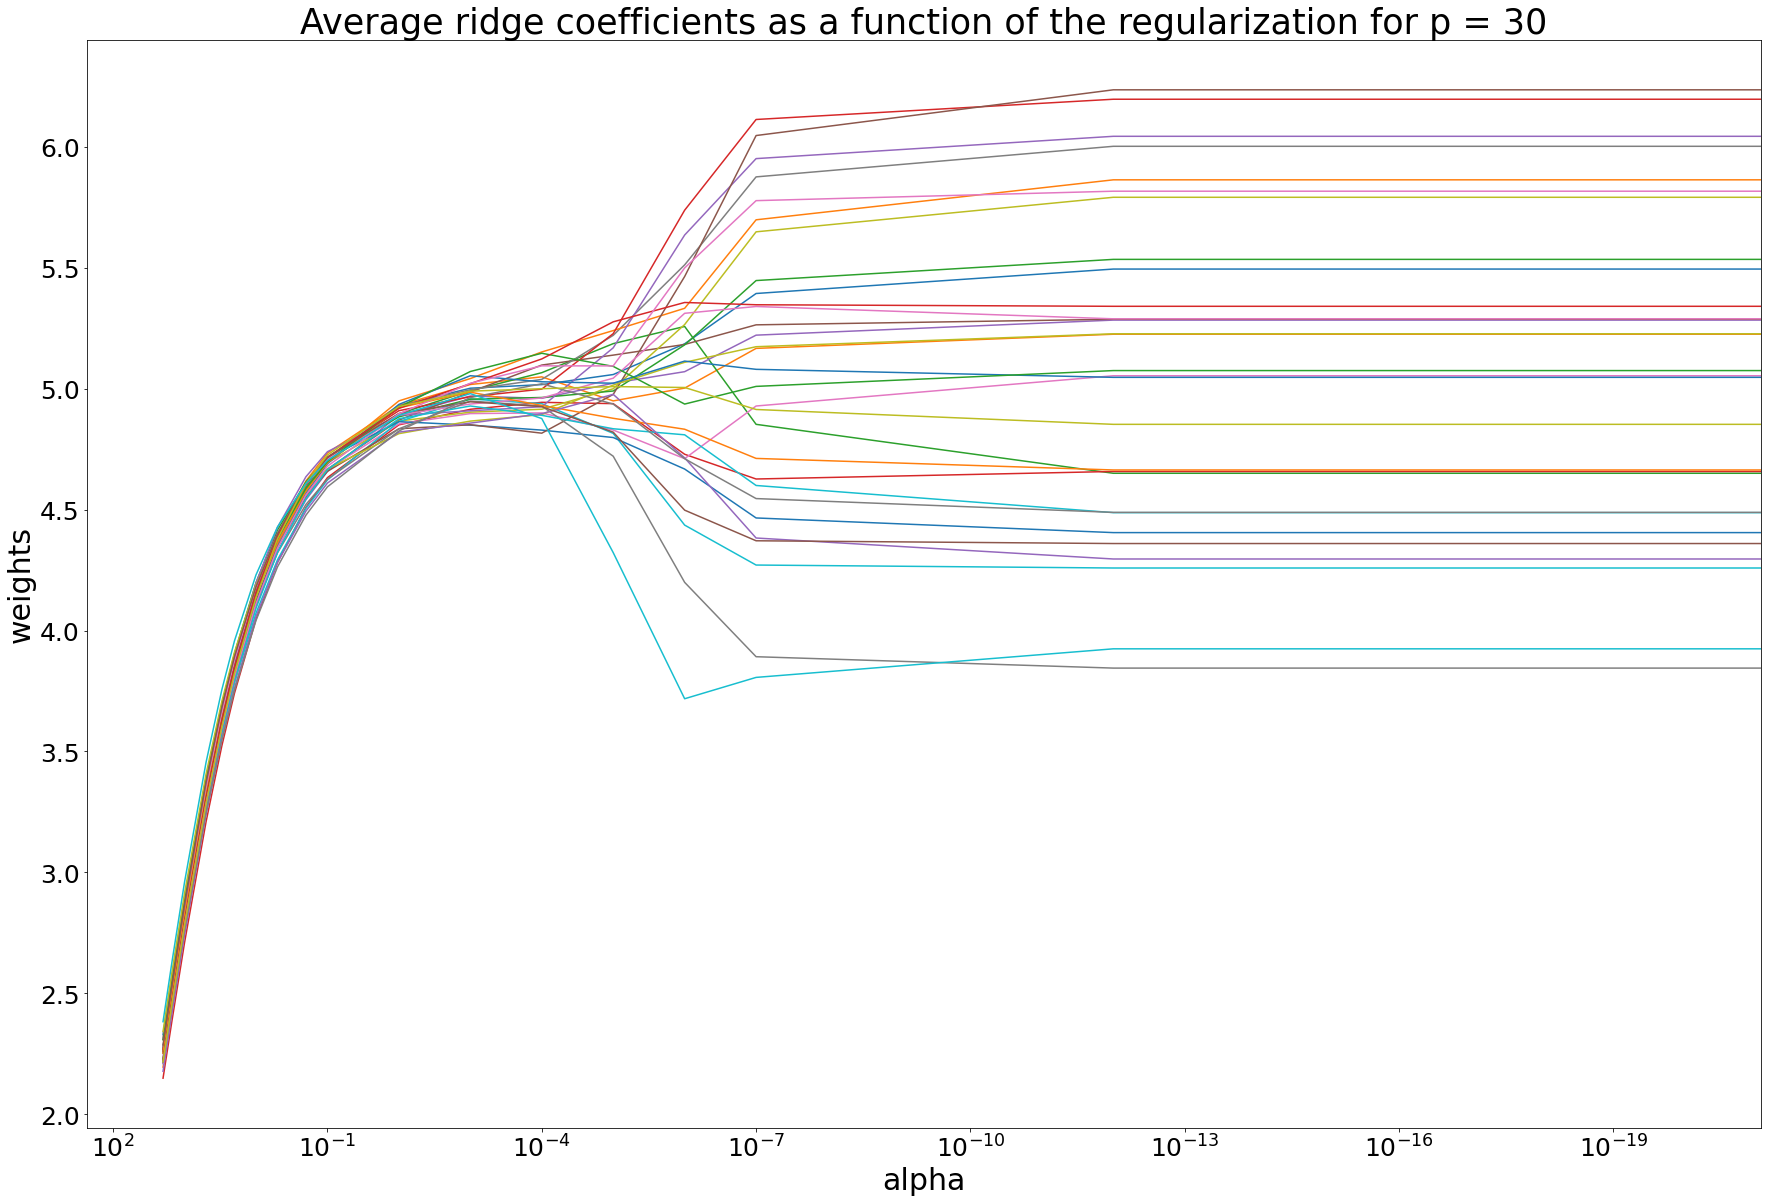

In [31]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_30)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.title("Average ridge coefficients as a function of the regularization for p = 30", fontsize = 35)
plt.axis("tight")
plt.show()



In [32]:
alphas = np.array([0, 0.00000000000000000001, 0.00000000000001, 0.000000000001]) 


df_list_betas_ridge_35, df_list_var_ridge_35 = iterate_ridge(n, 35, min_cor, max_cor, iterations_sim, np.repeat(5, 35), alphas)

mean_df_list_betas_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_betas_ridge_35) / iterations_sim
mean_df_list_var_ridge_35 = reduce(lambda x, y: x.add(y, fill_value = 0), df_list_var_ridge_35) / iterations_sim

mean_df_list_betas_ridge_35
mean_df_list_betas_ridge_35["alpha"] = alphas
mean_df_list_betas_ridge_35.set_index("alpha", inplace = True)
mean_df_list_betas_ridge_35
    
mean_df_list_var_ridge_35
mean_df_list_var_ridge_35["alpha"] = alphas
mean_df_list_var_ridge_35.set_index("alpha", inplace = True)
mean_df_list_var_ridge_35

,beta_var_1,beta_var_2,beta_var_3,beta_var_4,beta_var_5,beta_var_6,beta_var_7,beta_var_8,beta_var_9,beta_var_10,...,beta_var_26,beta_var_27,beta_var_28,beta_var_29,beta_var_30,beta_var_31,beta_var_32,beta_var_33,beta_var_34,beta_var_35
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,-1.986027e+16,1.280261e+17,-1.982515e+17,-9.452330e+15,-1.238165e+16,-1.193153e+17,-3.045692e+16,1.182600e+16,-4.869099e+16,6.941295e+16,...,5.157983e+17,-3.885167e+16,6.788060e+16,9.342916e+15,-1.876827e+17,-1.295518e+15,2.381996e+17,-1.288633e+17,-1.193071e+16,1.785616e+17
1.000000e-20,-1.986027e+16,1.280261e+17,-1.982515e+17,-9.452330e+15,-1.238165e+16,-1.193153e+17,-3.045692e+16,1.182600e+16,-4.869099e+16,6.941295e+16,...,5.157983e+17,-3.885167e+16,6.788060e+16,9.342916e+15,-1.876827e+17,-1.295518e+15,2.381996e+17,-1.288633e+17,-1.193071e+16,1.785616e+17
1.000000e-14,-4.379130e+12,-4.349331e+12,-5.021861e+12,-5.479036e+12,-3.976486e+12,-4.022845e+12,-3.710022e+12,-4.356436e+12,-4.109941e+12,-4.315681e+12,...,-5.354778e+12,-4.517183e+12,-4.411845e+12,-3.725690e+12,-4.149741e+12,-4.304730e+12,-3.886218e+12,-4.278454e+12,-4.209470e+12,-4.378739e+12
1.000000e-12,-1.870513e+07,-2.929816e+07,-1.694768e+06,-3.834189e+06,2.103528e+06,-1.319992e+06,3.921980e+06,-8.566312e+05,-9.248797e+06,1.084122e+06,...,-1.522022e+07,5.213748e+06,-9.042161e+06,2.063085e+05,-7.533809e+06,-1.007917e+07,-1.739181e+07,9.306615e+06,-1.099109e+07,-9.924985e+06


In [33]:
mean_df_list_betas_ridge_35

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,...,beta_26,beta_27,beta_28,beta_29,beta_30,beta_31,beta_32,beta_33,beta_34,beta_35
alpha,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,-388.293504,91.401012,-252.463802,115.370432,69.975485,251.846739,1.761090,177.415967,364.587643,-486.576151,...,-96.862715,-234.728283,-42.362505,-115.588715,181.929225,16.670796,-2.115137,55.407378,10.770375,44.878721
1.000000e-20,-388.293504,91.401012,-252.463802,115.370432,69.975485,251.846739,1.761090,177.415967,364.587643,-486.576151,...,-96.862715,-234.728283,-42.362505,-115.588715,181.929225,16.670796,-2.115137,55.407378,10.770375,44.878721
1.000000e-14,2.456164,4.307498,2.282355,4.229733,4.334122,5.819610,5.536553,5.128167,6.040038,2.360046,...,3.390850,3.463440,4.178880,3.645085,5.273400,4.179155,4.221050,4.031340,4.335491,4.353948
1.000000e-12,4.297073,4.340212,4.244599,4.275088,4.246586,4.296415,4.387461,4.361698,4.432530,4.325454,...,4.169126,4.304908,4.282822,4.245781,4.318758,4.284847,4.291183,4.266974,4.367518,4.293130


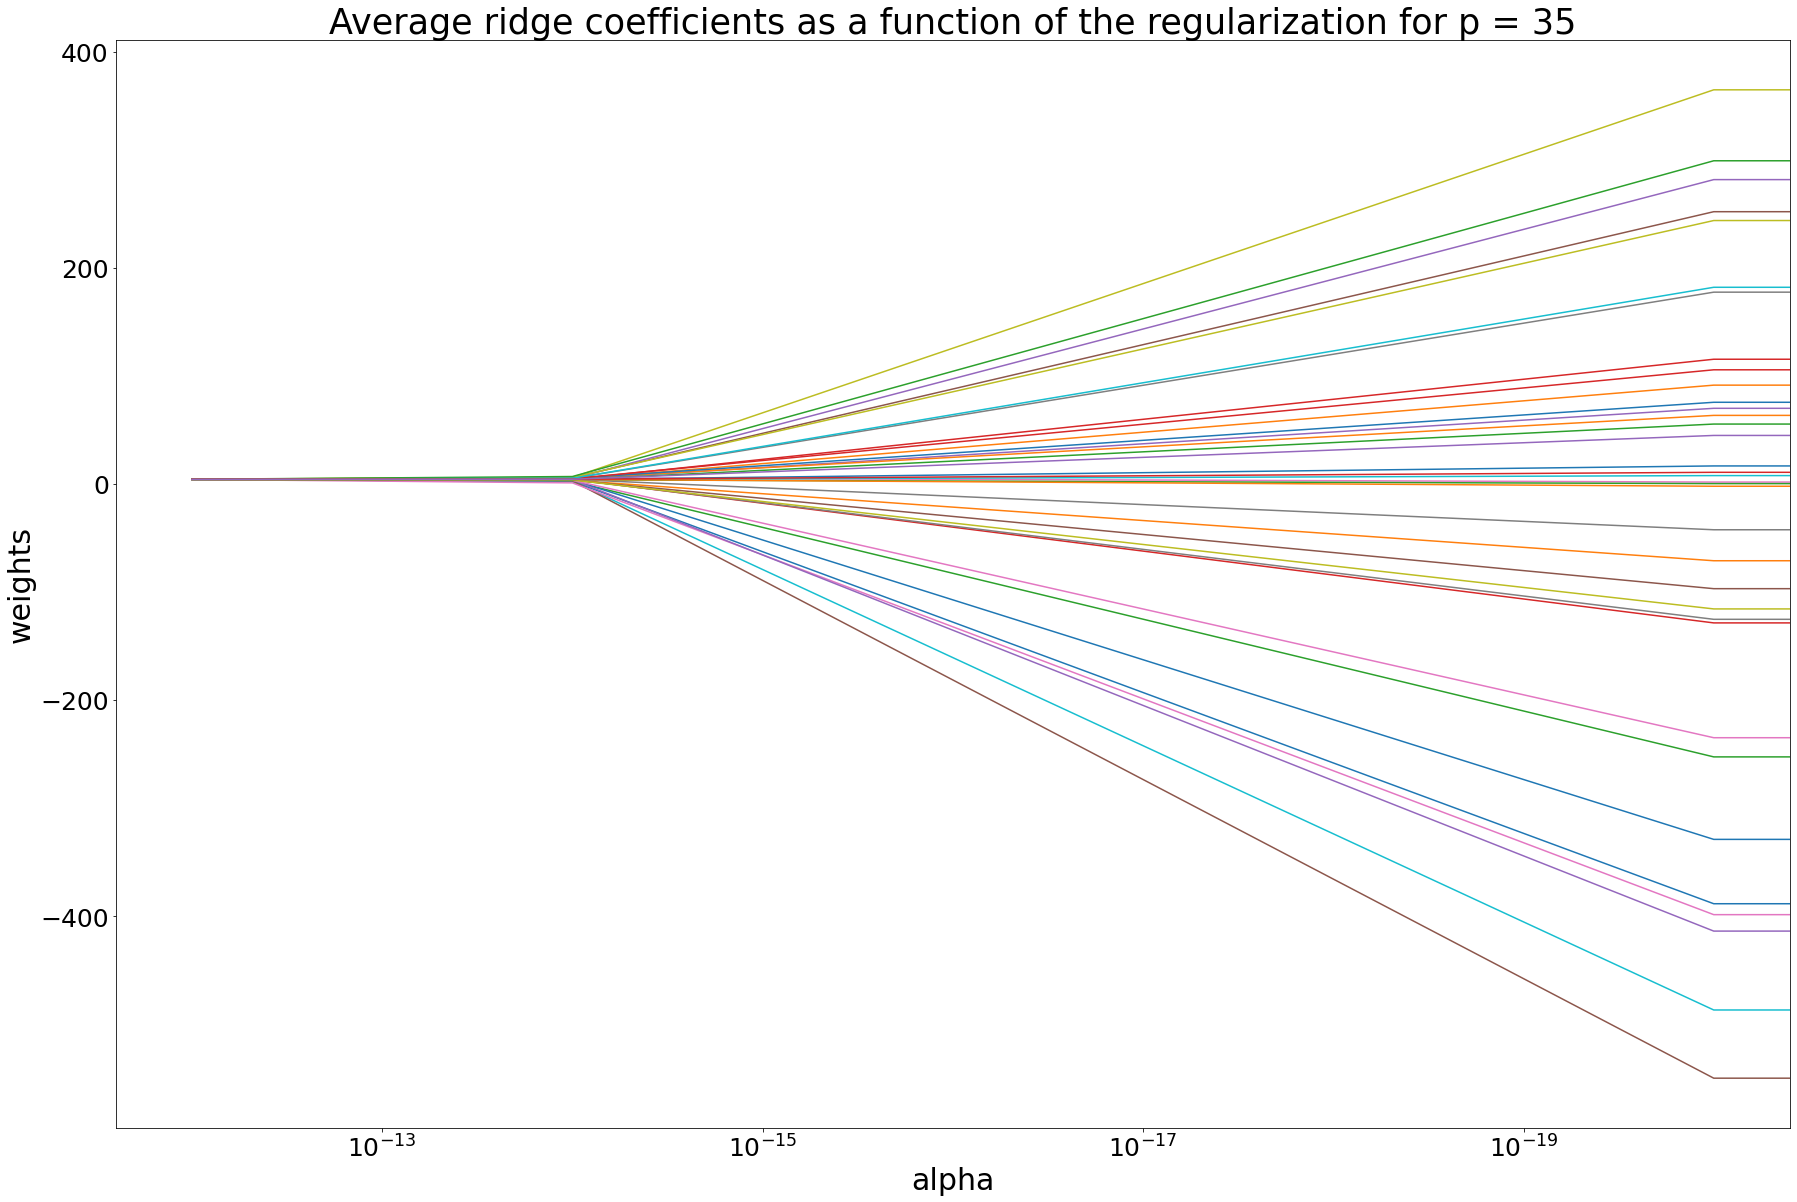

In [34]:
ax = plt.gca()

ax.plot(alphas, mean_df_list_betas_ridge_35)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.rcParams["figure.figsize"] = (30,20)
plt.xlabel("alpha", fontsize = 30)
plt.ylabel("weights", fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)


plt.title("Average ridge coefficients as a function of the regularization for p = 35", fontsize = 35)
plt.axis("tight")
plt.show()




## MSE Work 

In [74]:
n = 30
p = 35 
min_cor = 0 
max_cor = 0 
true_betas = np.repeat(5, p)




y_true_train, y_noise_train, X_train, df_train = get_sim_data(p, n, min_cor, max_cor, true_betas)
y_true_test, y_noise_test, X_test, df_test = get_sim_data(p, n, min_cor, max_cor, true_betas)



In [93]:
alphas = np.array([0, 0.00000000000000000001, 0.0000000000000000001, 0.000000000000000001, 0.00000000000000001, 0.000000000000001, 0.000000000001, 0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.35, 0.5, 1, 2]) 

save_mse = []
save_var = []
save_bias = []

for a in alphas: 
    ridge = Ridge(alpha=a).fit(X_train, y_noise_train)
    ridge_predict = ridge.predict(X_test)

    squared_dist = (ridge_predict - y_true_test)**2
    MSE = np.mean(squared_dist)
    save_mse.append(MSE)
    
    var_predicted_y = np.var(ridge_predict)
    save_var.append(var_predicted_y)
    
    bias_squared = (ridge_predict.mean() - y_true_test.mean())**2
    save_bias.append(bias_squared)
    
save_mse

/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.2543e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.2543e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.2543e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.2543e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/emilyschwab/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

[91.63521265134065,
 91.63521265134065,
 91.63521265134065,
 91.63521265134065,
 91.63521265134065,
 91.63521265134065,
 91.63521265129127,
 91.63521215893161,
 91.6347202534053,
 91.63028966956087,
 91.58608241637799,
 91.15369735762275,
 87.65269705869243,
 85.05758205273213,
 84.11890355581724,
 83.36339658439462,
 82.7606499063736,
 81.65203851597609,
 82.15388594826705,
 90.22333325338039]

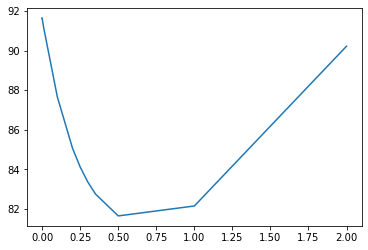

In [94]:
plt.plot(alphas, save_mse)
#plt.plot(np.log(alphas), save_var)

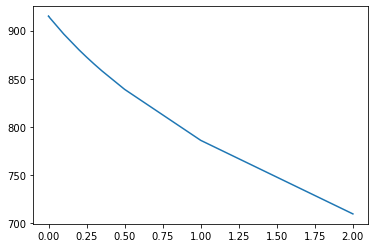

In [95]:
plt.plot(alphas, save_var)

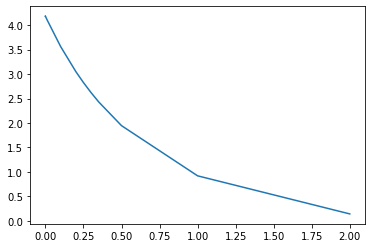

In [96]:
plt.plot(alphas, save_bias)

In [97]:
MSE_test= np.array(save_var) + np.array(save_bias)
MSE_test
len(save_var)
len(save_bias)
len(MSE_test)

20

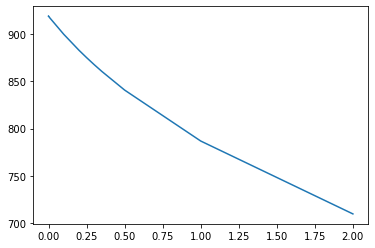

In [98]:
plt.plot(alphas, MSE_test)